In [1]:
# Importa las librerias requeridas para el proyecto
import numpy as np
import tensorflow as tf
import sionna

2025-09-19 14:30:12.584388: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2025-09-19 14:30:12.816488: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:467] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1758310212.895320    1165 cuda_dnn.cc:8579] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1758310212.916565    1165 cuda_blas.cc:1407] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
W0000 00:00:1758310213.089877    1165 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linking 

In [2]:
# Parametros del sistema
N = 1024 # longitud del código
K = 512 # número de bits de información (antes de CRC)
coderate = K/N # tasa del código
bitsxsimb = 2 # bits por símbolo (QPSK)
EBNO_DB_MIN = 0
EBNO_DB_MAX = 15
LOTE = 100 # tamaño de lote para ploteo

In [3]:
class SinCodigCanalAWGN(sionna.phy.Block):
    def __init__(self, N, bitsxsimb=2):
        super().__init__()
        self.bitsxsimb = bitsxsimb
        self.N = N
        
        # Inicializa los bloques necesarios
        self.datos = sionna.phy.mapping.BinarySource()
        self.constelacion = sionna.phy.mapping.Constellation("qam", bitsxsimb)
        self.mapeador = sionna.phy.mapping.Mapper(constellation=self.constelacion)
        self.demapeador = sionna.phy.mapping.Demapper("app", constellation=self.constelacion)
        self.awgn = sionna.phy.channel.AWGN()
    
    def call(self, batch_size, ebno_db):
        # Codificación
        b = self.datos([batch_size, self.N])

        # Mapeo
        x = self.mapeador(b)
        
        # Canal AWGN
        no = sionna.phy.utils.ebnodb2no(ebno_db, self.bitsxsimb, coderate=1.0)
        y = self.awgn(x, no)
        
        # Demapeo
        llr = self.demapeador(y, no)
        
        return b, llr

In [4]:
# Se inicializa el sistema con los bits congelados aleatorios
sistema_aleatorio = SinCodigCanalAWGN(N, bitsxsimb=bitsxsimb)

I0000 00:00:1758310230.189018    1165 gpu_device.cc:2019] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 9579 MB memory:  -> device: 0, name: NVIDIA RTX 3500 Ada Generation Laptop GPU, pci bus id: 0000:01:00.0, compute capability: 8.9


EbNo [dB] |        BER |       BLER |  bit errors |    num bits | block errors |  num blocks | runtime [s] |    status
---------------------------------------------------------------------------------------------------------------------------------------
      0.0 | 7.8486e-02 | 1.0000e+00 |        8037 |      102400 |          100 |         100 |         1.3 |reached target block errors
      1.0 | 5.7988e-02 | 1.0000e+00 |        5938 |      102400 |          100 |         100 |         0.0 |reached target block errors
      2.0 | 3.8086e-02 | 1.0000e+00 |        3900 |      102400 |          100 |         100 |         0.0 |reached target block errors
      3.0 | 2.2412e-02 | 1.0000e+00 |        2295 |      102400 |          100 |         100 |         0.0 |reached target block errors
      4.0 | 1.2070e-02 | 1.0000e+00 |        1236 |      102400 |          100 |         100 |         0.0 |reached target block errors
      5.0 | 5.9277e-03 | 9.9500e-01 |        1214 |      204800 |

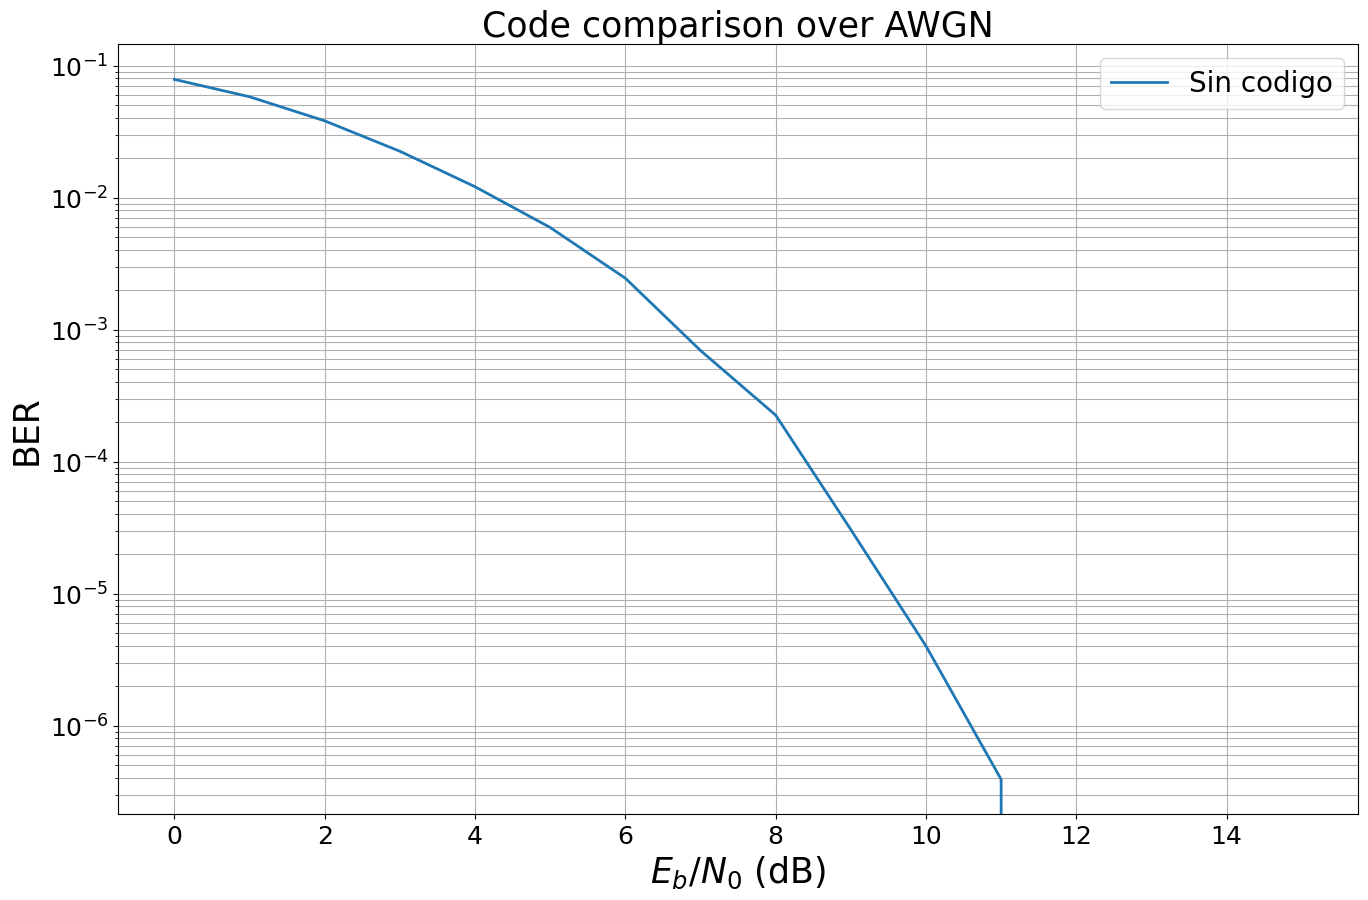

In [5]:
ber_plots = sionna.phy.utils.PlotBER("Code comparison over AWGN")
ber_plots.simulate(sistema_aleatorio,
                   ebno_dbs=np.linspace(EBNO_DB_MIN, EBNO_DB_MAX, 16),
                   batch_size=LOTE,
                   num_target_block_errors=100,
                   legend="Sin codigo",
                   soft_estimates=True,
                   max_mc_iter=100,
                   show_fig=True);

In [7]:
# Generador Monte Carlo de bits congelados para canal AWGN
# Parámetros del sistema
simulaciones = 5000
snr_prueba = 2.0
no = sionna.phy.utils.ebnodb2no(snr_prueba, bitsxsimb, coderate=coderate)

# Simulacion Monte Carlo
BER_bits = np.zeros(N)
datos = sionna.phy.mapping.BinarySource()
constelacion = sionna.phy.mapping.Constellation("qam", bitsxsimb)
mapeador = sionna.phy.mapping.Mapper(constellation=constelacion)
demapeador = sionna.phy.mapping.Demapper("app", constellation=constelacion)
awgn = sionna.phy.channel.AWGN()

for i in range(N):
    bits_congelados = np.array([j for j in range(N) if j != i])
    codificador = sionna.phy.fec.polar.encoding.PolarEncoder(bits_congelados, N)
    decodificador = sionna.phy.fec.polar.decoding.PolarSCLDecoder(bits_congelados, N, list_size=1)
    
    # Se generan simulaciones sobre el canal AWGN
    bits = datos([simulaciones, 1])
    bits_codif = codificador(bits)
    x = mapeador(bits_codif)
    y = awgn(x, no)
    llr = demapeador(y, no)
    bits_decodif = decodificador(llr)

    errores = tf.not_equal(bits, bits_decodif)
    BER_bits[i] = tf.reduce_mean(tf.cast(errores, tf.float32))

# Resultados Monte Carlo
indices_ordenados = np.argsort(BER_bits)
bits_congelados = indices_ordenados[-(N-K):]

In [8]:
# Sistema completo de codificación polar con canal AWGN
class CodPolarCanalAWGN(sionna.phy.Block):
    def __init__(self, N, K, bits_congelados, CRC_tipo="CRC24A", lista_SCL=8, bitsxsimb=2):
        super().__init__()
        self.N = N
        self.K = K
        self.K_datos = K - 24  # Asumiendo CRC24A
        self.bits_congelados = bits_congelados
        self.CRC_tipo = CRC_tipo
        self.lista_SCL = lista_SCL
        self.bitsxsimb = bitsxsimb
        
        # Inicializa los bloques necesarios
        self.datos = sionna.phy.mapping.BinarySource()
        self.CRC_codif = sionna.phy.fec.crc.CRCEncoder(CRC_tipo)
        self.polar_codif = sionna.phy.fec.polar.encoding.PolarEncoder(bits_congelados, N)
        self.constelacion = sionna.phy.mapping.Constellation("qam", bitsxsimb)
        self.mapeador = sionna.phy.mapping.Mapper(constellation=self.constelacion)
        self.demapeador = sionna.phy.mapping.Demapper("app", constellation=self.constelacion)
        self.awgn = sionna.phy.channel.AWGN()
        self.polar_decodif = sionna.phy.fec.polar.decoding.PolarSCLDecoder(bits_congelados, N, list_size=lista_SCL)
        self.CRC_decodif = sionna.phy.fec.crc.CRCDecoder(crc_encoder=self.CRC_codif)
    
    def call(self, batch_size, ebno_db):
        # Codificación
        b = self.datos([batch_size, self.K_datos])
        data_con_crc = self.CRC_codif(b)
        bits_codif = self.polar_codif(data_con_crc)

        # Mapeo
        x = self.mapeador(bits_codif)
        
        # Canal AWGN
        no = sionna.phy.utils.ebnodb2no(ebno_db, self.bitsxsimb, coderate=self.K/self.N)
        y = self.awgn(x, no)
        
        # Demapeo
        llr = self.demapeador(y, no)
        
        # Decodificación
        words_decodif = self.polar_decodif(llr)
        b_hat, crc_ok = self.CRC_decodif(words_decodif)
        
        return b, b_hat, llr, crc_ok

In [9]:
# Se inicializa el sistema con los bits congelados obtenidos por Monte Carlo para canal AWGN
sistema_awgn = CodPolarCanalAWGN(N, K, bits_congelados, bitsxsimb=bitsxsimb)

# @tf.function() # devuelve una versión acelerada
# def acelerado(batch_size, ebno_db):
#     return sistema(batch_size, ebno_db)

# b_hat, b, llr, crc_ok = sistema(LOTE, EBNO_DB_MAX)
# print(b.shape)  # debería ser (1, 488)
# print(b_hat.shape)  # debería ser (1, 488)
# print(crc_ok)  # debería ser True

EbNo [dB] |        BER |       BLER |  bit errors |    num bits | block errors |  num blocks | runtime [s] |    status
---------------------------------------------------------------------------------------------------------------------------------------
      0.0 | 3.8211e-01 | 9.4500e-01 |      111883 |      292800 |          567 |         600 |        44.7 |reached target block errors
      1.0 | 5.7698e-02 | 2.6684e-01 |       53498 |      927200 |          507 |        1900 |       137.0 |reached target block errors
      2.0 | 7.0984e-04 | 9.6000e-03 |         866 |     1220000 |           24 |        2500 |       170.7 |reached max iterations
      3.0 | 4.9180e-06 | 4.0000e-04 |           6 |     1220000 |            1 |        2500 |       184.7 |reached max iterations
      4.0 | 0.0000e+00 | 0.0000e+00 |           0 |     1220000 |            0 |        2500 |       184.3 |reached max iterations

Simulation stopped as no error occurred @ EbNo = 4.0 dB.



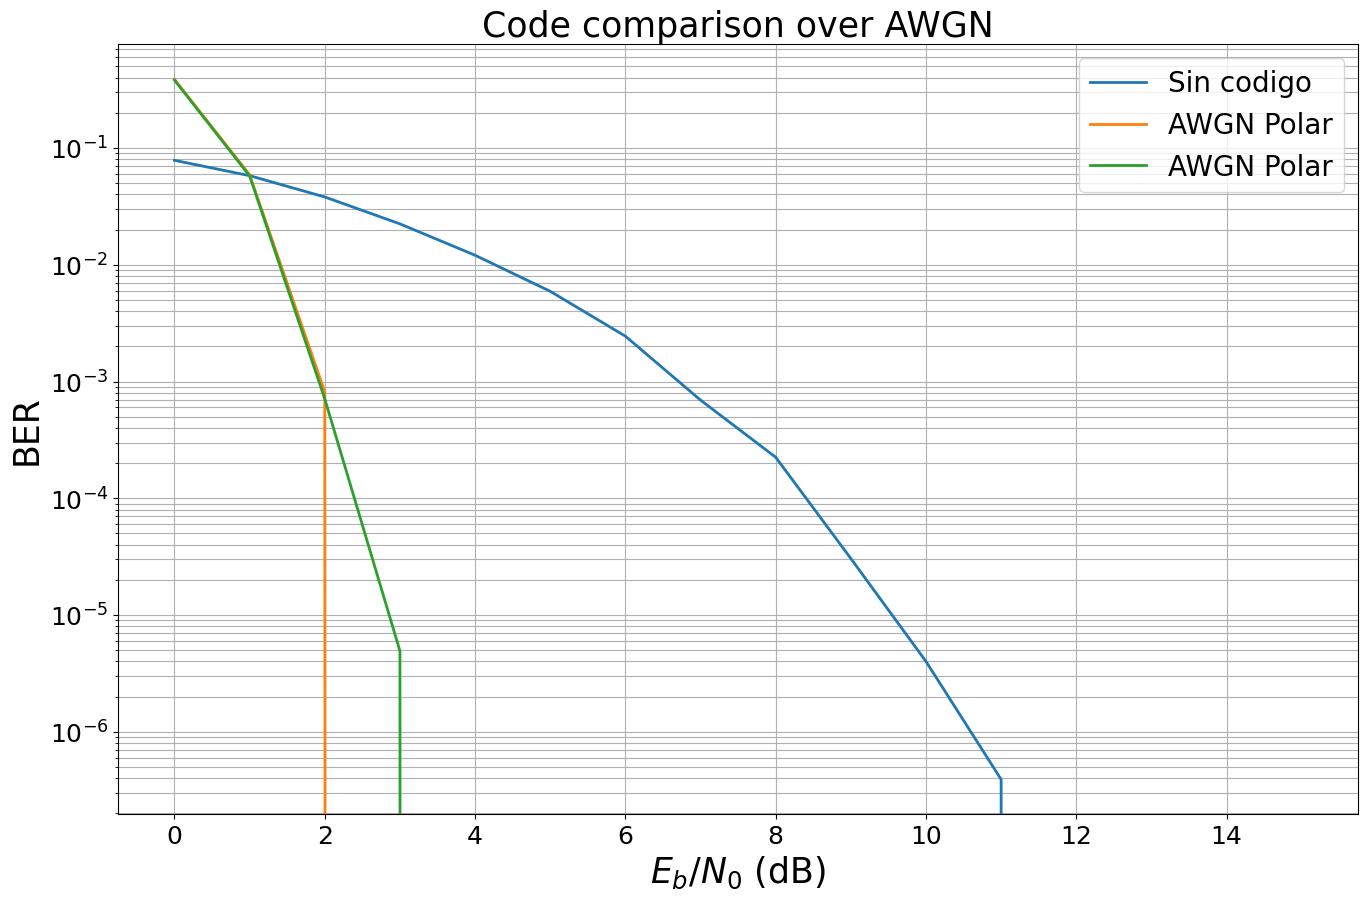

In [11]:
# Ploteo de la tasa de error para AWGN Polar
ber_plots.simulate(sistema_awgn,
                   ebno_dbs=np.linspace(EBNO_DB_MIN, EBNO_DB_MAX, 16),
                   batch_size=LOTE,
                   num_target_block_errors=500,
                   legend="AWGN Polar",
                   soft_estimates=False,
                   max_mc_iter=25,
                   show_fig=True,
                   forward_keyboard_interrupt=False);